In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import sys
sys.path.append("../")

# functions
from src.evaluation.evaluation_metrics import print_evaluation_metrics, plot_roc_curve, plot_heatmap_confusion_matrix

from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from src.preprocessing.agg_invoice import (
    agg_invoice_num_mode_no_monthly_weighting,
    agg_invoice_num_mode_monthly_weighting,
)
from src.preprocessing.cleaning import convert_dtype_cat_date

# Modeling
from xgboost import XGBClassifier

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from matplotlib.ticker import PercentFormatter

plt.rcParams.update(
    {"figure.figsize": (8, 5), "axes.facecolor": "white", "axes.edgecolor": "black"}
)
plt.rcParams["figure.facecolor"] = "w"
pd.plotting.register_matplotlib_converters()
pd.set_option("display.float_format", lambda x: "%.3f" % x)


# Define a plotting style to be used for all plots in this notebook
plt.style.use("tableau-colorblind10")

In [3]:
with open('../data/data_ready_for_models.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
data.keys()
print("def")

def


In [7]:
X_train, X_test, y_train, y_test, df_combined, df_combined_encoded, X_train_resampled, y_train_resampled = data.values()

In [9]:
X_train.columns.value_counts()

counter_statue_5      2
counter_statue_1      2
counter_statue_4      2
counter_code_201.0    1
counter_code_305.0    1
                     ..
region_312            1
region_311            1
region_310            1
region_309            1
counter_type_GAZ      1
Name: count, Length: 103, dtype: int64

In [10]:
#drop columns which are twice in the dataset
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [11]:
# modeling with XGBOOST

xg_boost_model = XGBClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
xg_boost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25558    28]
 [ 1492    21]]
---------------------------------------------------------------------------
Accuracy : 
 94.39093693494225
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.43      0.01      0.03      1513

    accuracy                           0.94     27099
   macro avg       0.69      0.51      0.50     27099
weighted avg       0.92      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.7790579561928928


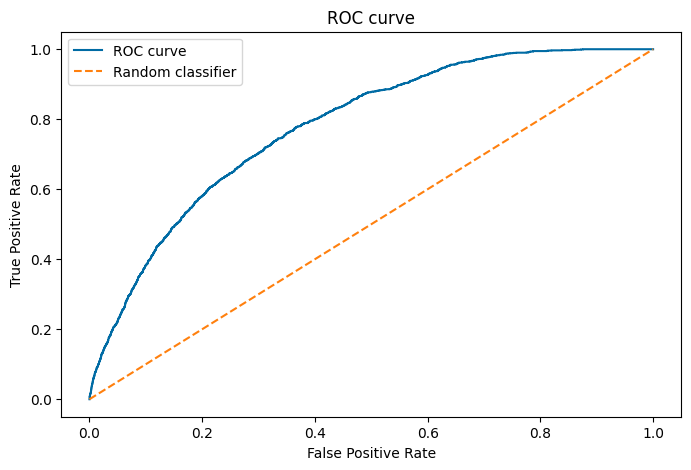

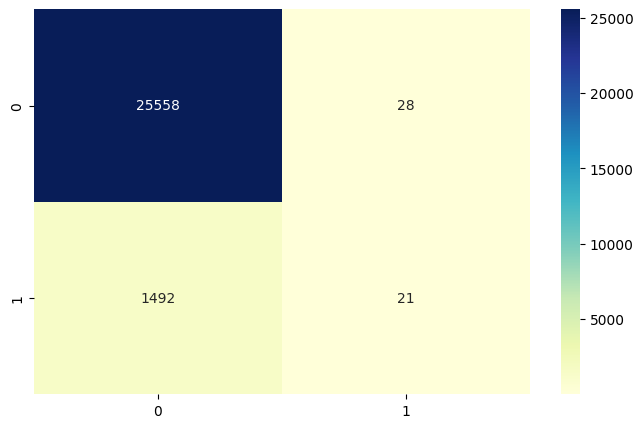

In [12]:
y_train_pred = xg_boost_model.predict(X_train)
y_test_pred = xg_boost_model.predict(X_test)

y_train_pred_proba = xg_boost_model.predict_proba(X_train)
y_test_pred_proba = xg_boost_model.predict_proba(X_test)

'''print_evaluation_metrics(y_train, y_train_pred, y_train_pred_proba)
plot_roc_curve(y_train, y_train_pred_proba)
plot_heatmap_confusion_matrix(y_train, y_train_pred)'''

print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

### Random Search for Best Parameters for XGBoost

In [26]:
from sklearn.model_selection import RandomizedSearchCV


params = {"n_estimators": list(range(5,100)),
          "learning_rate":list(np.linspace(0.1,1,10)),               
          #"max_depth": [None]+list(range(3,30))
          }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(XGBClassifier(), params, scoring='roc_auc',
                   verbose=5, n_jobs=-1, n_iter=5, random_state=10)

In [27]:
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END learning_rate=1.0, n_estimators=10;, score=0.757 total time=  12.4s
[CV 2/3] END learning_rate=1.0, n_estimators=10;, score=0.762 total time=  12.7s
[CV 2/3] END learning_rate=0.2, n_estimators=12;, score=0.761 total time=  14.7s
[CV 1/3] END learning_rate=0.2, n_estimators=12;, score=0.756 total time=  14.7s
[CV 3/3] END learning_rate=0.2, n_estimators=12;, score=0.757 total time=  14.8s
[CV 3/3] END learning_rate=1.0, n_estimators=10;, score=0.756 total time=  11.8s
[CV 1/3] END learning_rate=0.2, n_estimators=16;, score=0.762 total time=  17.9s
[CV 2/3] END learning_rate=0.2, n_estimators=16;, score=0.765 total time=  17.0s
[CV 3/3] END learning_rate=0.2, n_estimators=16;, score=0.761 total time=  15.2s
[CV 3/3] END learning_rate=0.5, n_estimators=60;, score=0.756 total time=  55.1s
[CV 2/3] END learning_rate=0.5, n_estimators=60;, score=0.756 total time=  55.7s
[CV 1/3] END learning_rate=0.5, n_estimators=60;,

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5, 0.6,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 14, 15, 16, 17,
                                                         18, 19, 20, 21, 22, 23,
                                                         24, 25, 26, 27, 28, 29,
                                                         30, 31, 32, 33, 34, ...]},
                   random_state=42, scoring='roc_auc', verbose=5)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25563    23]
 [ 1497    16]]
---------------------------------------------------------------------------
Accuracy : 
 94.39093693494225
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.41      0.01      0.02      1513

    accuracy                           0.94     27099
   macro avg       0.68      0.50      0.50     27099
weighted avg       0.91      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.780941563847835


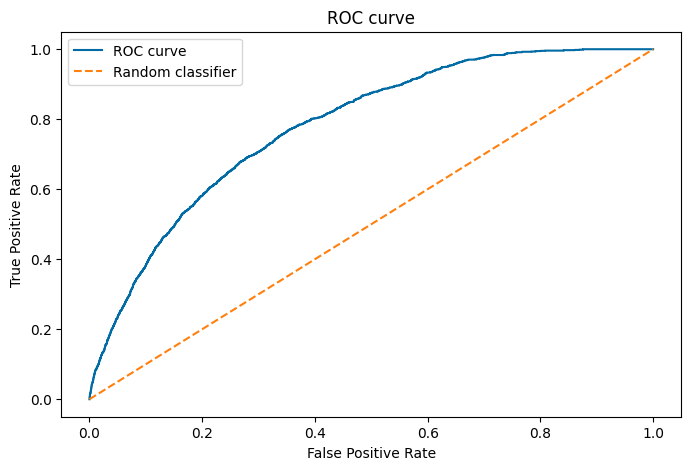

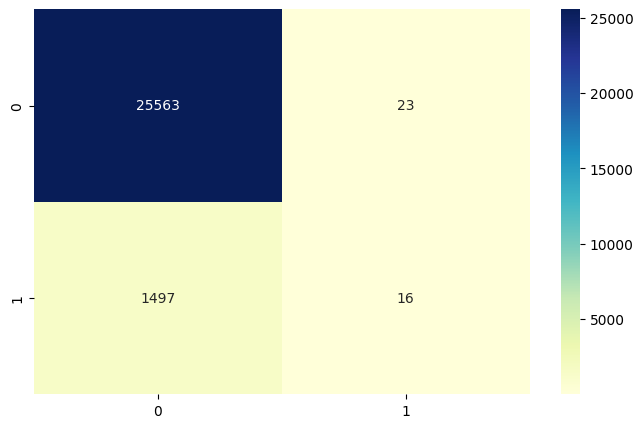

In [31]:
best_boost = rs.best_estimator_

#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

In [32]:
# summarize results
print("Best: %f using %s" % (rs.best_score_, rs.best_params_))
means = rs.cv_results_['mean_test_score']
stds = rs.cv_results_['std_test_score']
params = rs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

Best: 0.769773 using {'n_estimators': 85, 'learning_rate': 0.30000000000000004}
0.757892 (0.001938) with: {'n_estimators': 12, 'learning_rate': 0.2}
0.757259 (0.001841) with: {'n_estimators': 60, 'learning_rate': 0.5}
0.758218 (0.002675) with: {'n_estimators': 10, 'learning_rate': 1.0}
0.769773 (0.001947) with: {'n_estimators': 85, 'learning_rate': 0.30000000000000004}
0.762774 (0.001597) with: {'n_estimators': 16, 'learning_rate': 0.2}


NameError: name 'learning_rate' is not defined

In [33]:
from sklearn.model_selection import GridSearchCV


n_estimators = list(range(5,100,10))
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs.fit(X_train, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 3/3] END learning_rate=0.0001, n_estimators=5;, score=0.726 total time=   9.5s
[CV 2/3] END learning_rate=0.0001, n_estimators=5;, score=0.732 total time=   9.6s
[CV 1/3] END learning_rate=0.0001, n_estimators=5;, score=0.724 total time=   9.6s
[CV 2/3] END learning_rate=0.0001, n_estimators=15;, score=0.738 total time=  18.8s
[CV 1/3] END learning_rate=0.0001, n_estimators=15;, score=0.727 total time=  19.1s
[CV 3/3] END learning_rate=0.0001, n_estimators=15;, score=0.728 total time=  19.1s
[CV 2/3] END learning_rate=0.0001, n_estimators=25;, score=0.738 total time=  29.9s
[CV 1/3] END learning_rate=0.0001, n_estimators=25;, score=0.728 total time=  29.9s
[CV 3/3] END learning_rate=0.0001, n_estimators=25;, score=0.733 total time=  26.6s
[CV 2/3] END learning_rate=0.0001, n_estimators=35;, score=0.738 total time=  34.8s
[CV 1/3] END learning_rate=0.0001, n_estimators=35;, score=0.728 total time=  35.1s
[CV 3/3] END lear

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'n_estimators': [5, 15, 25, 35, 45, 55, 65, 75, 85,
                                          95]},
             scoring='roc_auc', verbose=5)

Best: 0.777645 using {'learning_rate': 0.1, 'n_estimators': 95}
0.727408 (0.003172) with: {'learning_rate': 0.0001, 'n_estimators': 5}
0.731312 (0.005020) with: {'learning_rate': 0.0001, 'n_estimators': 15}
0.733204 (0.004067) with: {'learning_rate': 0.0001, 'n_estimators': 25}
0.733139 (0.003962) with: {'learning_rate': 0.0001, 'n_estimators': 35}
0.733139 (0.003946) with: {'learning_rate': 0.0001, 'n_estimators': 45}
0.734051 (0.002963) with: {'learning_rate': 0.0001, 'n_estimators': 55}
0.734185 (0.002859) with: {'learning_rate': 0.0001, 'n_estimators': 65}
0.734219 (0.002979) with: {'learning_rate': 0.0001, 'n_estimators': 75}
0.734272 (0.003053) with: {'learning_rate': 0.0001, 'n_estimators': 85}
0.734308 (0.003040) with: {'learning_rate': 0.0001, 'n_estimators': 95}
0.733177 (0.003965) with: {'learning_rate': 0.001, 'n_estimators': 5}
0.734481 (0.003013) with: {'learning_rate': 0.001, 'n_estimators': 15}
0.734604 (0.003019) with: {'learning_rate': 0.001, 'n_estimators': 25}
0.736

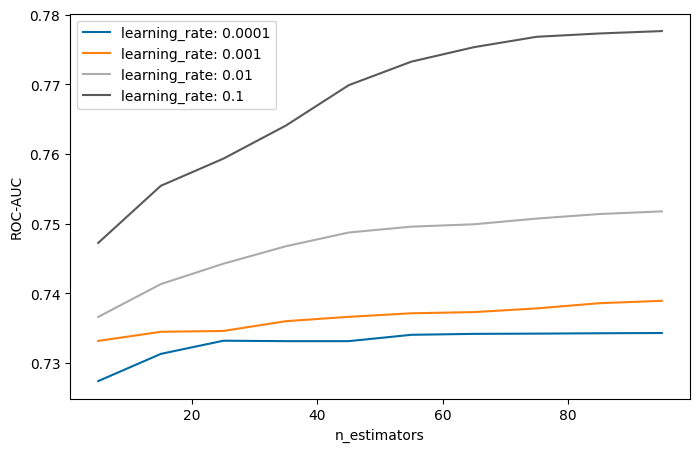

In [35]:
# summarize results
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

In [36]:
gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 95}

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25584     2]
 [ 1510     3]]
---------------------------------------------------------------------------
Accuracy : 
 94.42045831949518
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.60      0.00      0.00      1513

    accuracy                           0.94     27099
   macro avg       0.77      0.50      0.49     27099
weighted avg       0.93      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.7836961503391566


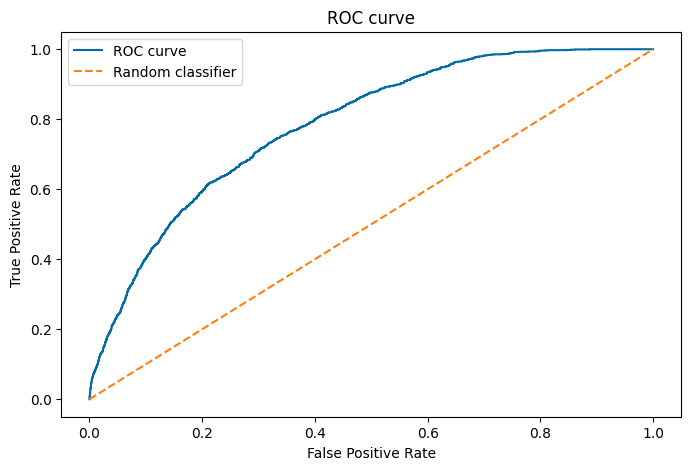

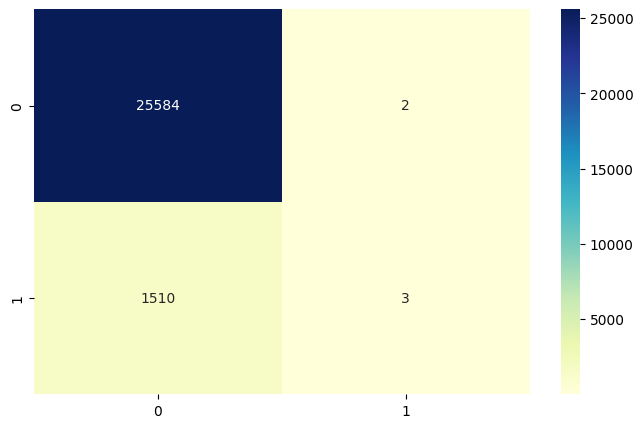

In [37]:
best_boost = gs.best_estimator_

#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

In [40]:

n_estimators = list(range(65,140,10))
learning_rate = list(np.linspace(0.1,1,10))
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 2/3] END learning_rate=0.1, n_estimators=65;, score=0.779 total time=  30.3s
[CV 1/3] END learning_rate=0.1, n_estimators=65;, score=0.775 total time=  31.0s
[CV 3/3] END learning_rate=0.1, n_estimators=65;, score=0.773 total time=  31.0s
[CV 2/3] END learning_rate=0.1, n_estimators=75;, score=0.780 total time=  34.9s
[CV 1/3] END learning_rate=0.1, n_estimators=75;, score=0.776 total time=  35.1s
[CV 3/3] END learning_rate=0.1, n_estimators=75;, score=0.774 total time=  35.3s
[CV 1/3] END learning_rate=0.1, n_estimators=85;, score=0.777 total time=  39.6s
[CV 2/3] END learning_rate=0.1, n_estimators=85;, score=0.781 total time=  40.5s
[CV 3/3] END learning_rate=0.1, n_estimators=85;, score=0.774 total time=  43.2s
[CV 2/3] END learning_rate=0.1, n_estimators=95;, score=0.782 total time=  48.5s
[CV 1/3] END learning_rate=0.1, n_estimators=95;, score=0.777 total time=  49.5s
[CV 3/3] END learning_rate=0.1, n_estimators=95

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0],
                         'n_estimators': [65, 75, 85, 95, 105, 115, 125, 135]},
             scoring='roc_auc', verbose=5)

Best: 0.777861 using {'learning_rate': 0.1, 'n_estimators': 135}
0.775336 (0.002453) with: {'learning_rate': 0.1, 'n_estimators': 65}
0.776826 (0.002750) with: {'learning_rate': 0.1, 'n_estimators': 75}
0.777302 (0.002793) with: {'learning_rate': 0.1, 'n_estimators': 85}
0.777645 (0.003192) with: {'learning_rate': 0.1, 'n_estimators': 95}
0.777662 (0.003050) with: {'learning_rate': 0.1, 'n_estimators': 105}
0.777499 (0.002685) with: {'learning_rate': 0.1, 'n_estimators': 115}
0.777820 (0.002338) with: {'learning_rate': 0.1, 'n_estimators': 125}
0.777861 (0.002630) with: {'learning_rate': 0.1, 'n_estimators': 135}
0.777009 (0.001537) with: {'learning_rate': 0.2, 'n_estimators': 65}
0.777543 (0.001175) with: {'learning_rate': 0.2, 'n_estimators': 75}
0.777182 (0.001078) with: {'learning_rate': 0.2, 'n_estimators': 85}
0.777002 (0.001153) with: {'learning_rate': 0.2, 'n_estimators': 95}
0.776208 (0.000830) with: {'learning_rate': 0.2, 'n_estimators': 105}
0.775582 (0.000898) with: {'learn

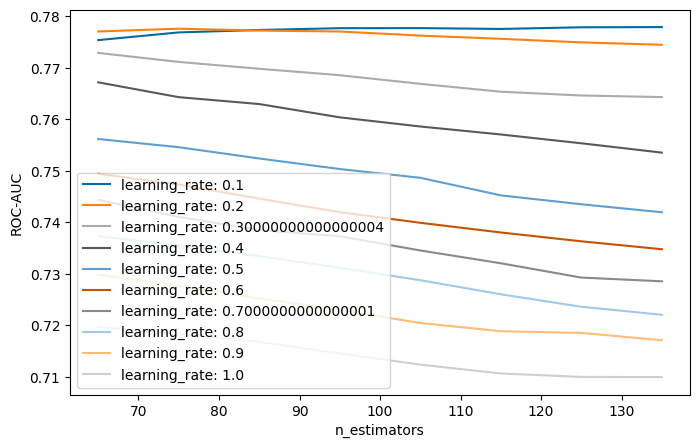

In [41]:
# summarize results
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=135, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>
---------------------------------------------------------------------------
Confusion Matrix: 
 [[25582     4]
 [ 1506     7]]
---------------------------------------------------------------------------
Accuracy

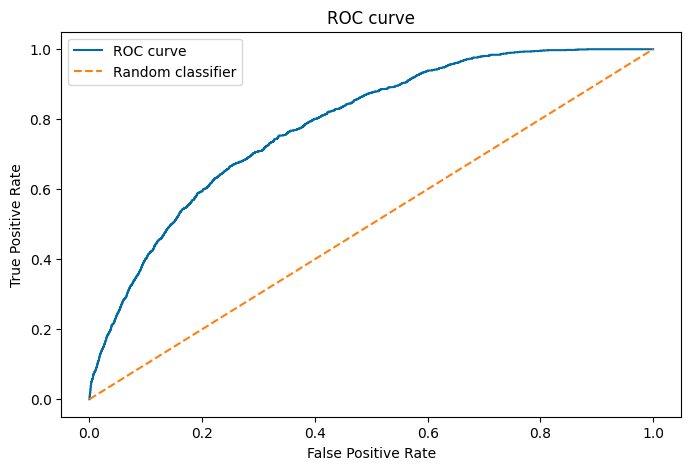

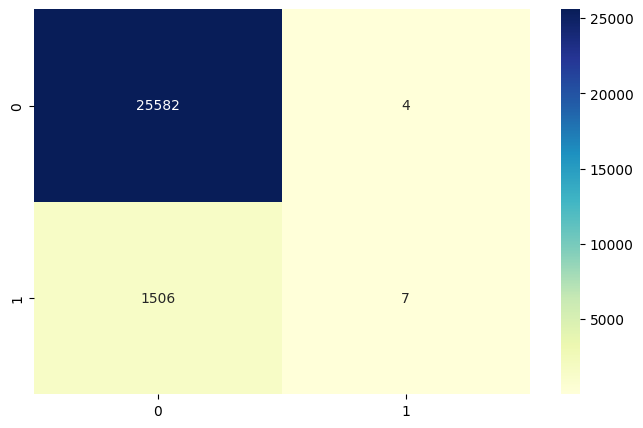

In [52]:
best_boost = gs.best_estimator_
print(best_boost.get_params)
#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)


In [45]:

n_estimators = list(range(15,80,5))
learning_rate = list(np.linspace(0.2,0.5,8))
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs_n = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs_n.fit(X_train, y_train)

Fitting 3 folds for each of 104 candidates, totalling 312 fits


[CV 2/3] END learning_rate=0.2, n_estimators=15;, score=0.763 total time=   7.5s
[CV 1/3] END learning_rate=0.2, n_estimators=15;, score=0.762 total time=   7.7s
[CV 3/3] END learning_rate=0.2, n_estimators=15;, score=0.760 total time=   7.9s
[CV 1/3] END learning_rate=0.2, n_estimators=20;, score=0.765 total time=  10.2s
[CV 2/3] END learning_rate=0.2, n_estimators=20;, score=0.769 total time=  10.3s
[CV 3/3] END learning_rate=0.2, n_estimators=20;, score=0.765 total time=  10.4s
[CV 1/3] END learning_rate=0.2, n_estimators=25;, score=0.770 total time=  12.5s
[CV 2/3] END learning_rate=0.2, n_estimators=25;, score=0.774 total time=  12.9s
[CV 3/3] END learning_rate=0.2, n_estimators=25;, score=0.770 total time=  13.3s
[CV 1/3] END learning_rate=0.2, n_estimators=30;, score=0.773 total time=  15.6s
[CV 2/3] END learning_rate=0.2, n_estimators=30;, score=0.776 total time=  15.3s
[CV 3/3] END learning_rate=0.2, n_estimators=30;, score=0.773 total time=  16.1s
[CV 1/3] END learning_rate=0

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.24285714285714288,
                                           0.2857142857142857,
                                           0.32857142857142857,
                                           0.37142857142857144,
                                           0.4142857142857143,
                                           0.45714285714285713, 0.5],
                         'n_estimators': [15, 20, 25, 30, 35, 40, 45, 50, 55,
                                          60, 65, 70, 75]},
             scoring='roc_auc', verbose=5)

Best: 0.777543 using {'learning_rate': 0.2, 'n_estimators': 75}
0.761429 (0.001380) with: {'learning_rate': 0.2, 'n_estimators': 15}
0.766684 (0.001728) with: {'learning_rate': 0.2, 'n_estimators': 20}
0.771213 (0.001858) with: {'learning_rate': 0.2, 'n_estimators': 25}
0.774059 (0.001381) with: {'learning_rate': 0.2, 'n_estimators': 30}
0.775565 (0.002152) with: {'learning_rate': 0.2, 'n_estimators': 35}
0.776376 (0.002542) with: {'learning_rate': 0.2, 'n_estimators': 40}
0.776784 (0.002306) with: {'learning_rate': 0.2, 'n_estimators': 45}
0.776782 (0.002497) with: {'learning_rate': 0.2, 'n_estimators': 50}
0.776666 (0.002282) with: {'learning_rate': 0.2, 'n_estimators': 55}
0.776814 (0.001994) with: {'learning_rate': 0.2, 'n_estimators': 60}
0.777009 (0.001537) with: {'learning_rate': 0.2, 'n_estimators': 65}
0.777280 (0.001257) with: {'learning_rate': 0.2, 'n_estimators': 70}
0.777543 (0.001175) with: {'learning_rate': 0.2, 'n_estimators': 75}
0.764346 (0.000348) with: {'learning_ra

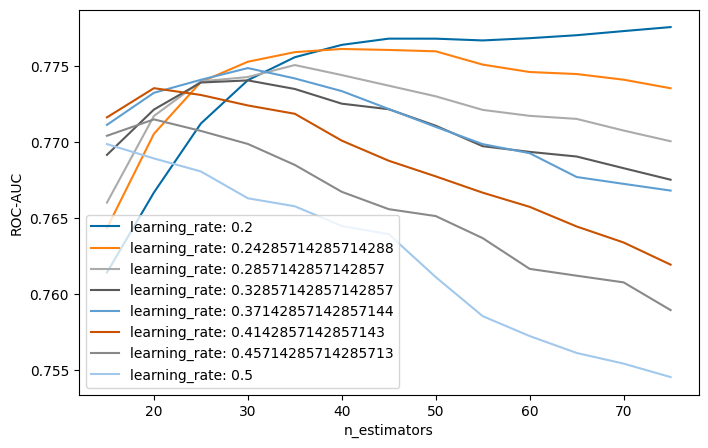

In [47]:
# summarize results
print("Best: %f using %s" % (gs_n.best_score_, gs_n.best_params_))
means = gs_n.cv_results_['mean_test_score']
stds = gs_n.cv_results_['std_test_score']
params = gs_n.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=75, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>
---------------------------------------------------------------------------
Confusion Matrix: 
 [[25575    11]
 [ 1504     9]]
---------------------------------------------------------------------------
Accuracy 

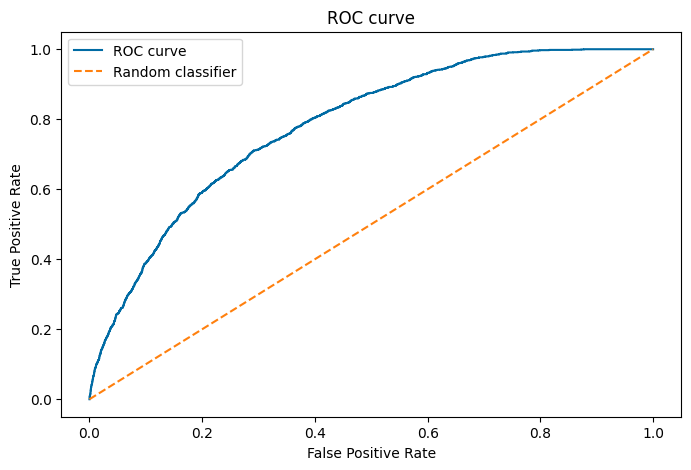

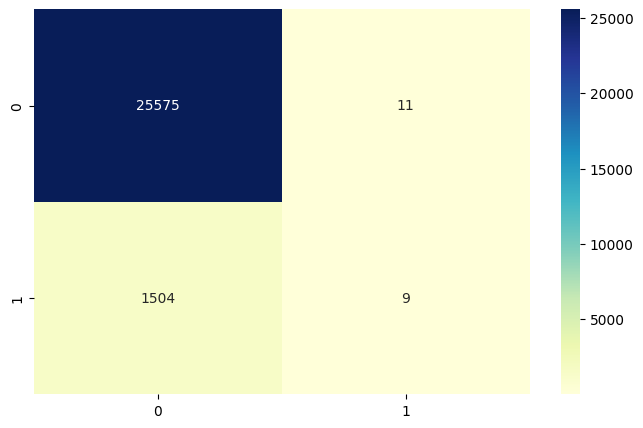

In [53]:
best_boost_n = gs_n.best_estimator_
print(best_boost_n.get_params)
#
y_test_pred = best_boost_n.predict(X_test)
y_test_pred_proba = best_boost_n.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)


In [55]:
#save results as pickle:
best_gs = gs
sec_best_gs = gs_n

data={"best_gs" : best_gs,
      "sec_best_gs": sec_best_gs, 
      "best_boost": best_boost
      }

with open('../models/xgboost/xgboost_grid_raw.pkl', 'wb') as f:
    pickle.dump(data,f)


,creation_date,months_number,invoice_date,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,district_62,district_63,...,counter_code_506.0,counter_code_532.0,counter_code_565.0,counter_code_600.0,reading_remarque_7.0,reading_remarque_8.0,reading_remarque_9.0,reading_remarque_203.0,reading_remarque_413.0,counter_type_GAZ
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_46032,1451001600000000000,3.636,1513877236363636480,1.000,161.812,43.288,65.463,129.325,False,False,...,False,False,False,False,False,False,True,False,False,False
train_Client_8884,1289606400000000000,4.000,1331436342857142784,1.000,119.536,49.911,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_80860,1225152000000000000,4.194,1389334296774193664,1.000,98.692,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_21716,467856000000000000,4.542,1384837200000000000,1.000,105.156,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,True,False,False,False
train_Client_95171,606700800000000000,3.877,1379907692307692288,1.000,66.548,0.000,0.000,0.000,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_107750,879984000000000000,4.000,1343085942857142784,1.000,249.786,53.714,6.018,0.000,True,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_59063,897436800000000000,3.731,1364120597014925312,1.000,79.760,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_68496,1215820800000000000,3.882,1392145411764705792,1.000,107.015,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
